In [1]:
import numpy as np

import text_utilities as tu
import regex as rex
%load_ext autoreload
%autoreload 2

In [17]:

pc = tu.PosCorpus('../data/experiment/verbs')

for i in range(1, len(pc.counted_corpus.keys())):
    print(i, len(pc.counted_corpus[i]))

1 10582
2 48722
3 69051
4 46298
5 18406
6 4945
7 979
8 164


In [2]:
class WordMapper:
    """Generates a Wordmap for a target token, comparing it to its POS-members in a dict sorted by syllables"""
    def __init__(self, target: str, tokenset: dict, clean=True, pattern='([^^1][0*1*]+[^$1])'):
        self.target = target
        self.tokenset = tokenset
        self.syllables = tu.count_syllables(target)
        self.maps = self.stack_maps(target, tokenset, self.syllables)
        self.pattern = pattern
        self.clean_maps = None
        if clean:
            self.filter_map_noise(self.maps, self.pattern)
            self.wordmap = self.sum_map_stack(self.clean_maps)
        else:
            self.wordmap = self.sum_map_stack(self.maps)


    def stack_maps(self, target, tokenset, syllables):
        l = len(target)
        #cc1, cc2, cc3 = 0,0,0
        maps = []
        for k in tokenset:
            for v in tokenset[k]:
                pair = (v, self.target)
                case = tu.match_ends(v, target)
                shorter = min(pair, key=len)
                longer = max(pair, key=len)
                diff = len(longer) - len(shorter)

                if case.get("any"):
                    if diff:
                        if case.get("first") and syllables!=1:
                            #cc1+=1
                            wm = tu.wordmap(longer=longer, shorter=shorter)
                            while len(wm) < l:
                                wm.append(0) # padding
                            maps.append(wm)

                        if case.get("last"):
                            wm = []
                            #cc2+=1
                            wm = tu.wordmap(longer=longer, shorter=shorter, start=diff)
                            while len(wm) < l:
                                wm.insert(0, 0) # padding
                            maps.append(wm)

                    else:
                        #cc3+=1
                        wm = tu.wordmap(longer=pair[0], shorter=pair[1])
                        maps.append(wm)
        #print("Cases:", cc1, cc2, cc3)
        return maps


    def filter_map_noise(self, maps, pattern):
        """Convert maps to strings and delete any consecutive '1' not at the start or end of the map"""
        str_maps = ["".join([str(c) for c in m]) for m in maps]  # cast to str
        recount_map = [rex.sub(pattern=pattern, repl=lambda m: len(m.group(1))*"0",string=sm) for sm in str_maps]  # regex sub
        regexed_listed = [list(i) for i in recount_map]  # into list form
        regexed_inted = [[int(c) for c in m] for m in regexed_listed]  # cast back to int
        self.clean_maps = regexed_inted

    def sum_map_stack(self, maps):
        return [sum(x) for x in zip(*maps)]


In [3]:
wordmapper = WordMapper("verdutzt", pc.counted_corpus, clean=True)
wordmapper.wordmap

NameError: name 'pc' is not defined

In [126]:
mt = MapToken(wordmapper.target, wordmapper.wordmap, pc.metrics)

In [127]:
mt.freqmap

{'e': (129905, 0.16219310599704342),
 't': (77211, 0.09640192376842863),
 'r': (68048, 0.08496144472412002),
 'u': (29988, 0.03744156778137361),
 'd': (14059, 0.01755338806983899),
 'z': (12020, 0.015007591194214711),
 'v': (8892, 0.011102121539014742)}

In [117]:
import collections as cl
import numpy as np
from scipy import stats
import wm_tokenizer as wmt
%load_ext autoreload
%autoreload 2
path_to_functional_morphemes = "../new_tokenizer/fun_vocab_raw.txt"
path_to_lexemic_morphemes = "../new_tokenizer/lex_vocab_raw.txt"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
with open(path_to_lexemic_morphemes, encoding="utf8", mode="r") as lv:
    lm_raw = lv.read().split("\n")
    lv.close()
lm_raw = lm_raw

with open(path_to_functional_morphemes, encoding="utf8", mode="r") as fv:
    fm_raw = fv.read().split("\n")
    fv.close()
fm_raw = fm_raw

In [ ]:
# cleaning and preselection of subvocabulary

fm_clean = [i for i in fm_raw if i != ""]
lm_clean = [i for i in lm_raw if (len(i) > 1) and (i not in fm_clean)]  # select only morphemes longer than 1 character
lm_ncount = cl.Counter(lm_clean).most_common()
n_o_lm = len(lm_clean)
lm_rel_pre = {k: (v / n_o_lm)+1 if ((len(k) > 2) and (k not in fm_clean)) else 0 for k, v in lm_ncount}  # len > 2 could be mean len of set(fm) -> int(2.47)
# functional morphemes: remove any str with len above 2.5 std (normalized)

fm_uni = list(set(fm_clean))
fm_outliers = [fm_uni[i] for i in np.where(np.abs(stats.zscore([len(i) for i in fm_uni])) > 2.5)[0]]
fm_uni_no_outliers = set(fm_uni) - set(fm_outliers)

fm_ncount = cl.Counter(fm_clean).most_common()
n_o_fm = len(fm_clean)
fm_rel = {k: v / n_o_fm if (len(k) > 1)  and (k in list(fm_uni_no_outliers)) else 0 for k, v in fm_ncount}


# lexical morphemes: use everything below median + median absolute deviation
lm_uni = list(set(lm_rel_pre))
lm_len = [len(i) for i in lm_uni]
lm_med = np.median(lm_len)
lm_mad = stats.median_abs_deviation(lm_len)
lm_outliers = set([lm_uni[i] for i in np.where(lm_med+lm_mad < lm_len)[0]])  # where(array > condition)
lm_uni_no_outliers = set(lm_uni) - set(lm_outliers)

lm_rel = {k: (v / n_o_lm) if (len(k) > 2) and (k not in fm_rel) and (k in list(lm_uni_no_outliers)) else 0 for k, v in lm_ncount}
lex_bias_no_outliers = {**lm_rel, **fm_rel}

In [114]:
wm = wmt.SequenceTokenizer(vocab=lex_bias_no_outliers, target="umgefallen")
print(wm.maxed)

['umge', 'fal', 'len']


In [126]:
len(lex_bias_no_outliers)

43695

In [137]:
import matplotlib.pyplot as pp # plotting

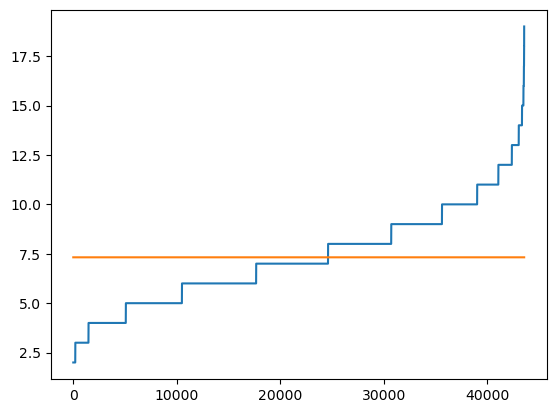

In [152]:
lmlen = [len(i) for i in lm_uni_no_outliers]
lmlen.sort()
lmfre = [lm_rel[i] for i in lm_uni_no_outliers]
pp.plot(range(len(lmfre)), lmlen)
pp.plot([lm_mean for i in range(len(lmfre))])


In [130]:
voc = tu.VerbDict()

43695

In [14]:
sum([l in lm_rel for l in wm.maxed])
for i in wm.segmentations:
    if int(sum([l in lm_rel for l in i])):
        print(i)

['her', 'aus', 'ge', 'fi', 'sch', 't']
['her', 'aus', 'ge', 'fisch', 't']
['her', 'aus', 'ge', 'fis', 'ch', 't']
['her', 'aus', 'ge', 'fis', 'cht']
['her', 'aus', 'gefi', 'sch', 't']
['her', 'aus', 'gefisch', 't']
['her', 'ausge', 'fi', 'sch', 't']
['her', 'ausge', 'fisch', 't']
['her', 'ausge', 'fis', 'ch', 't']
['her', 'ausge', 'fis', 'cht']
['he', 'ra', 'us', 'ge', 'fi', 'sch', 't']
['he', 'ra', 'us', 'ge', 'fisch', 't']
['he', 'ra', 'us', 'ge', 'fis', 'ch', 't']
['he', 'ra', 'us', 'ge', 'fis', 'cht']
['he', 'ra', 'us', 'gefi', 'sch', 't']
['he', 'ra', 'us', 'gefisch', 't']
['he', 'ra', 'usge', 'fi', 'sch', 't']
['he', 'ra', 'usge', 'fisch', 't']
['he', 'ra', 'usge', 'fis', 'ch', 't']
['he', 'ra', 'usge', 'fis', 'cht']
['he', 'raus', 'ge', 'fi', 'sch', 't']
['he', 'raus', 'ge', 'fisch', 't']
['he', 'raus', 'ge', 'fis', 'ch', 't']
['he', 'raus', 'ge', 'fis', 'cht']
['he', 'raus', 'gefi', 'sch', 't']
['he', 'raus', 'gefisch', 't']
